In [1]:
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.trainers import Trainer
from bayesflow.networks import InvertibleNetwork, SequenceNetwork

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit, expit
from os.path import join 
from cmdstanpy import CmdStanModel
from logging import getLogger

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

train = False

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


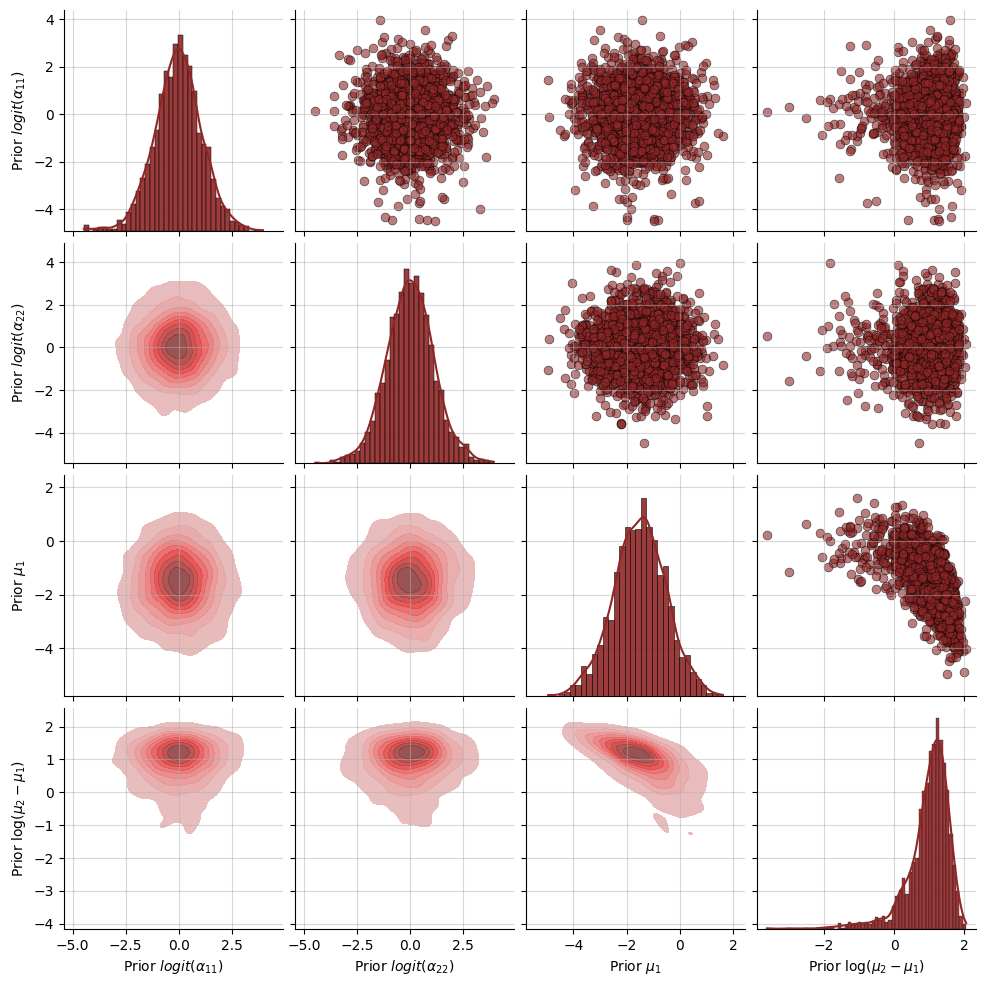

In [144]:
def prior_fun():
    a11 = np.random.beta(2, 2)
    a22 = np.random.beta(2, 2)

    
    mu = np.random.normal(loc=[-1.5, 1.5])
    while mu[1] < mu[0]: # order constraint
        mu = np.random.normal(loc=[-1.5, 1.5])

    # transform parameters into unconstrained real space
    return np.r_[logit(a11), logit(a22), mu[0], np.log(mu[1] - mu[0])]

prior = Prior(prior_fun=prior_fun, param_names=[r"$logit(\alpha_{11})$", r"$logit(\alpha_{22})$", r"$\mu_1$", r"$\log(\mu_2 - \mu_1)$"])


f = prior.plot_prior2d()

In [3]:
def simulator_fun(theta):
    a = [
        [expit(theta[0]), 1-expit(theta[0])],
        [1-expit(theta[1]), expit(theta[1])]
    ]
    mu = [theta[2], np.exp(theta[3]) + theta[2]]

    state = np.random.choice(a=[0, 1], p=[0.5, 0.5])
    observations = []

    for _ in range(100):
        y = np.random.normal(loc=mu[state])
        observations.append(y)

        state = np.random.choice(a=[0,1], p=a[state])
        

    return np.c_[observations]


simulator = Simulator(simulator_fun=simulator_fun)

model = GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [4]:
amortizer = AmortizedPosterior(
    inference_net = InvertibleNetwork(num_params=4, num_coupling_layers=10, coupling_design="spline"),
    summary_net = SequenceNetwork(summary_dim=12, num_conv_layers=4, bidirectional=True),
    summary_loss_fun="MMD"
)

In [5]:
trainer = Trainer(amortizer=amortizer, generative_model=model, checkpoint_path="checkpoints/hmm_example")

INFO:root:Loaded loss history from checkpoints/hmm_example/history_152.pkl.
INFO:root:Networks loaded from checkpoints/hmm_example/ckpt-152
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [6]:
if train:
    h = trainer.train_online(epochs=150, iterations_per_epoch=1000, batch_size=32)

In [7]:
if train:
    f=bf.diagnostics.plot_losses(h)

In [8]:
df=model(1000)
df=trainer.configurator(df)

In [9]:
z, _ = amortizer(df)

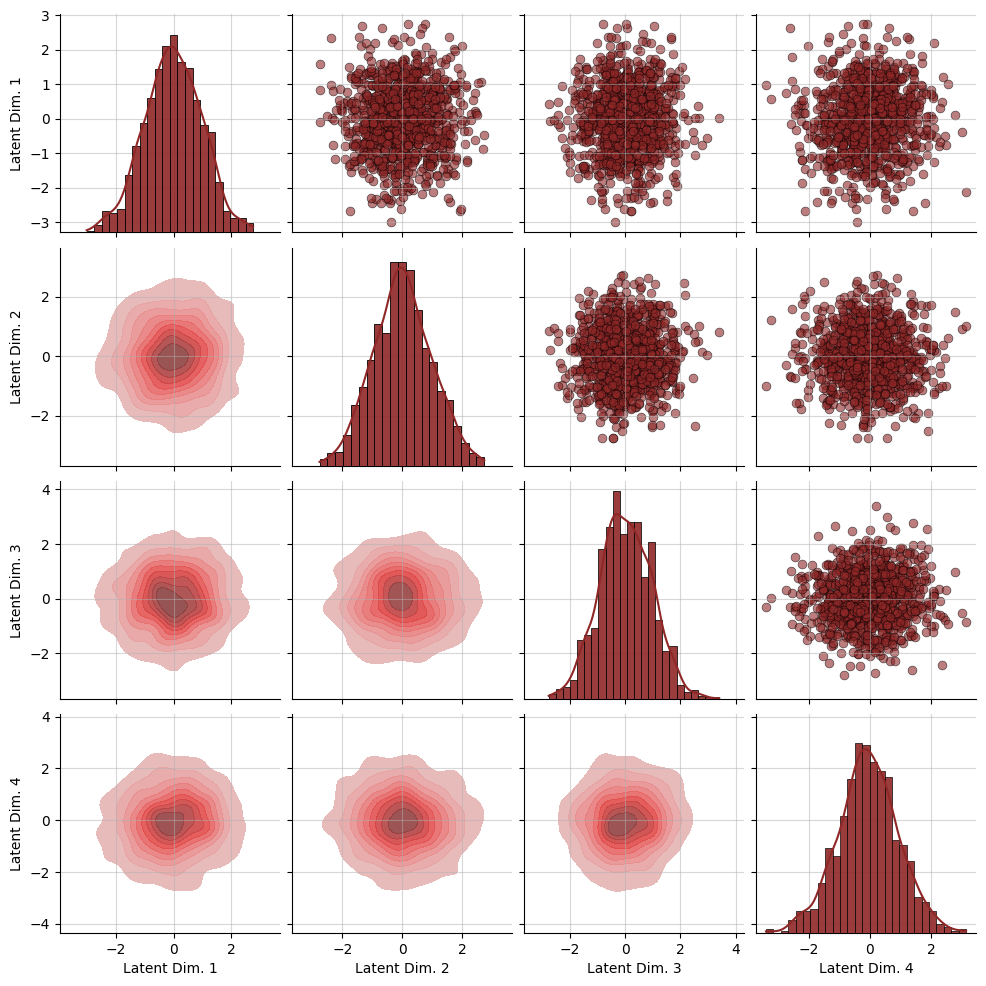

In [10]:
f = bf.diagnostics.plot_latent_space_2d(z)

In [11]:
prior_samples = df['parameters']
posterior_samples = amortizer.sample(df, n_samples=1000)

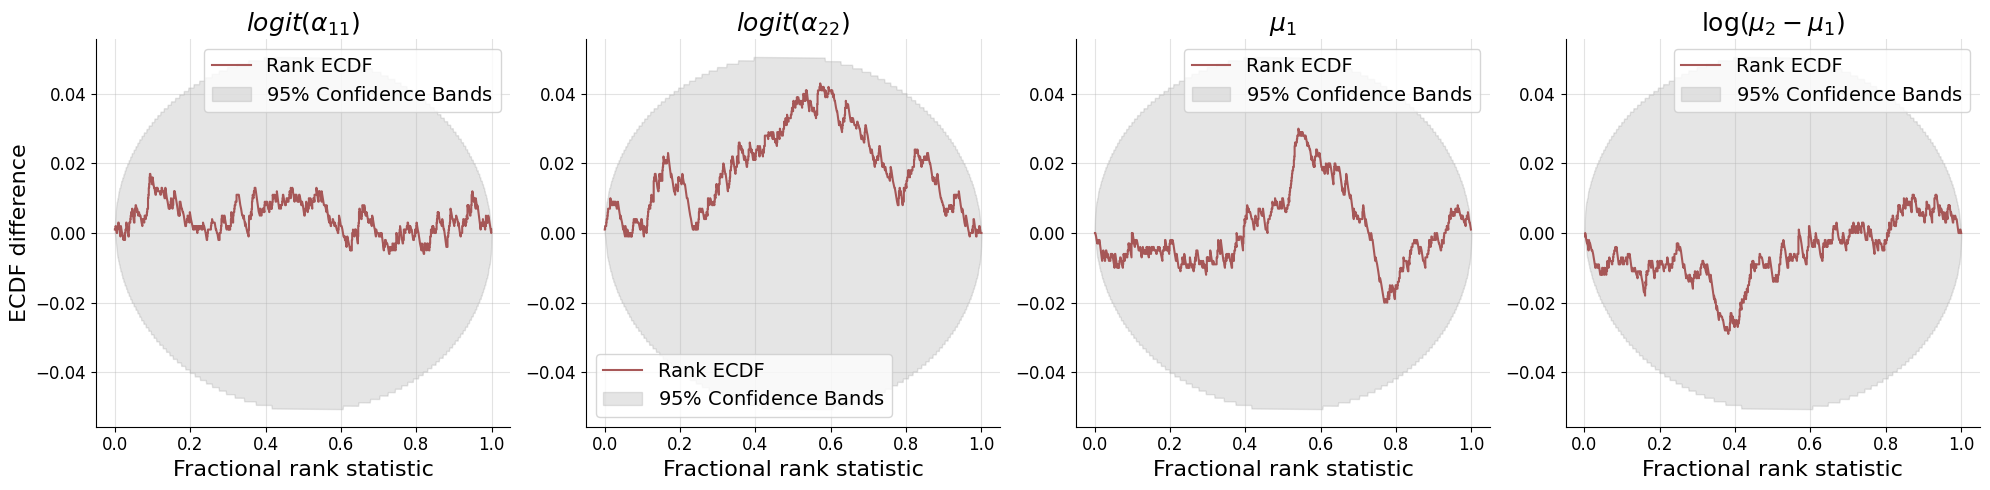

In [12]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples, difference=True, param_names=prior.param_names)

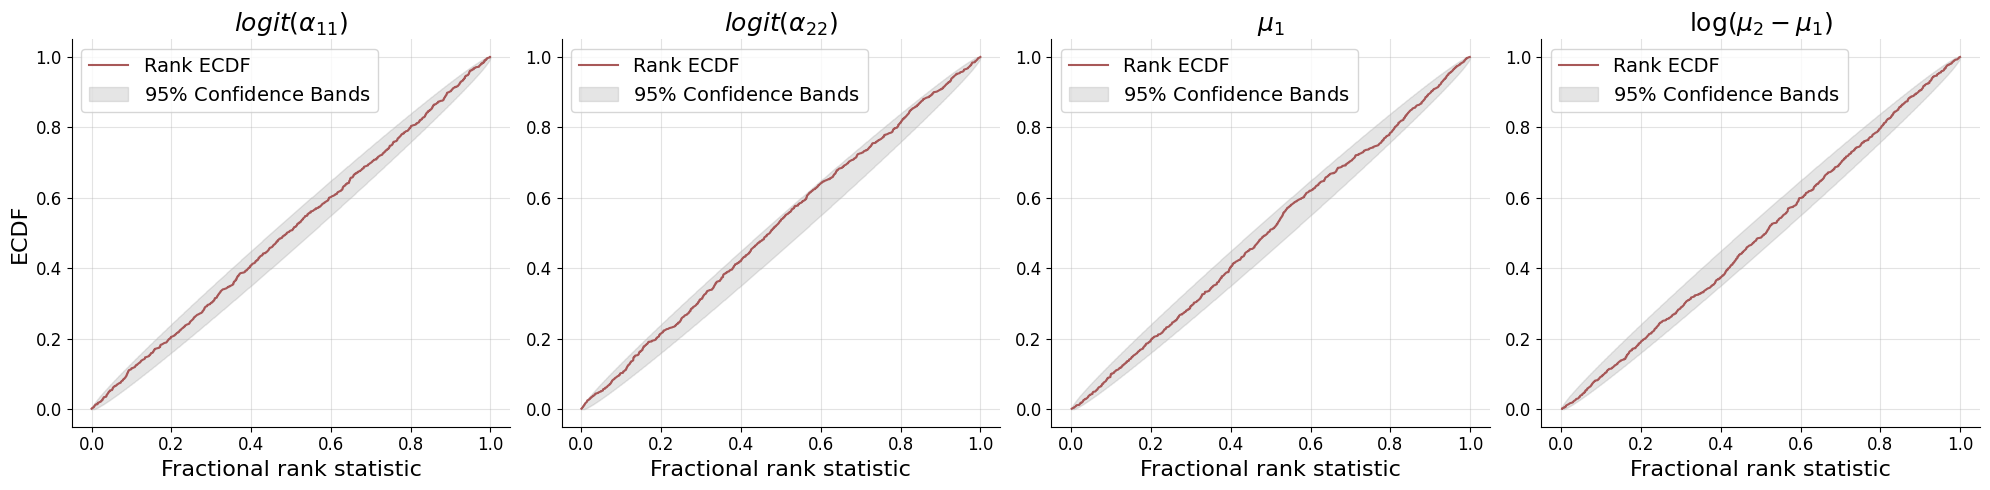

In [13]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples, param_names=prior.param_names)

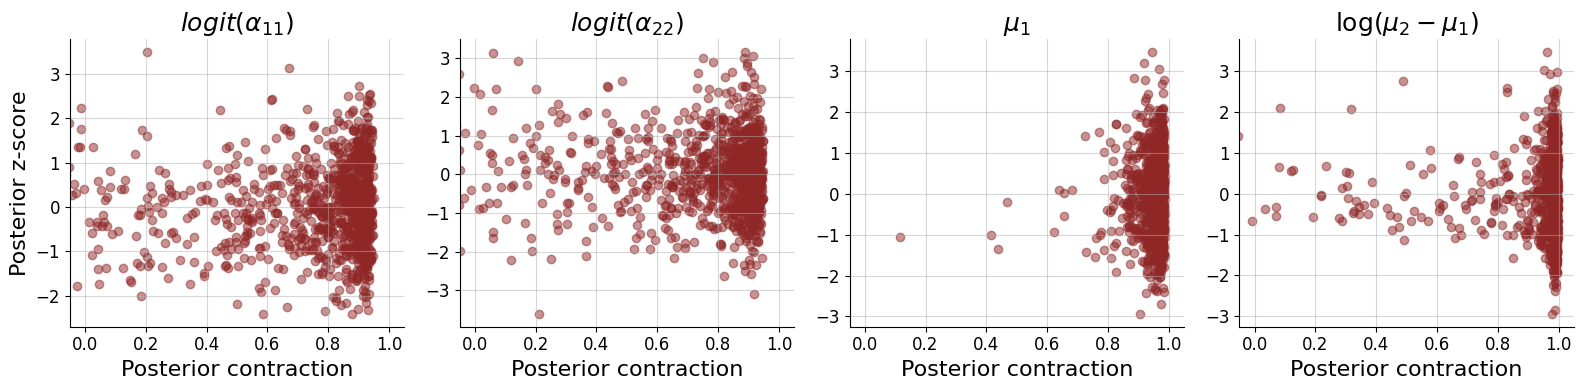

In [14]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_samples, param_names=prior.param_names)

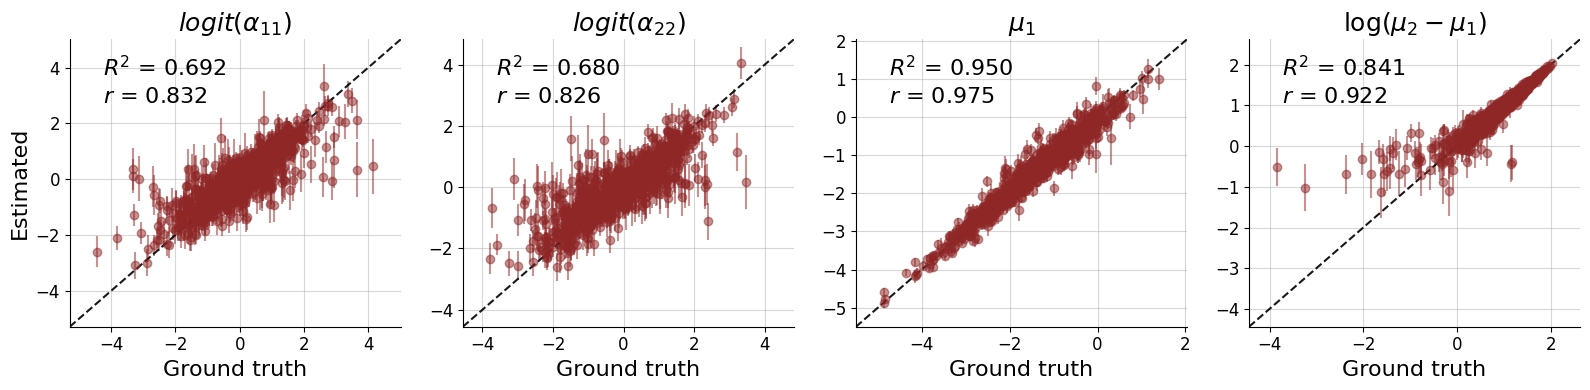

In [15]:
f = bf.diagnostics.plot_recovery(posterior_samples, prior_samples, param_names=prior.param_names)

## Compare to Stan

In [16]:
stan_model = CmdStanModel(stan_file=join('stan', 'normal-hmm.stan'))

In [150]:
data = model(1)

pars = data['prior_draws'][0]
pars[0] = expit(pars[0])
pars[1] = expit(pars[1])
pars[3] = pars[2] + np.exp(pars[3])

print(pars)

stan_data = {
    'n_obs': 100,
    'n_cls': 2,
    'alpha': [[2, 2], [2, 2]],
    'separation': 3,
    'y': data['sim_data'][0,:,0]
}

bf_data = trainer.configurator(data)

[ 0.0630141   0.64454322 -1.3295994   0.32146845]


In [151]:
stan_fit = stan_model.sample(stan_data, show_progress=False)
print(stan_fit.diagnose())

Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpq9djq6lf/normal-hmmw2x0fpjk/normal-hmm-20240621100737_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpq9djq6lf/normal-hmmw2x0fpjk/normal-hmm-20240621100737_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpq9djq6lf/normal-hmmw2x0fpjk/normal-hmm-20240621100737_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpq9djq6lf/normal-hmmw2x0fpjk/normal-hmm-20240621100737_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [152]:
stan_samples = stan_fit.draws_pd(vars=["transition_matrix", "mu"])
stan_samples = stan_samples[["transition_matrix[1,1]", "transition_matrix[2,2]", "mu[1]", "mu[2]"]]
stan_samples = np.array(stan_samples)

In [153]:
bf_samples = amortizer.sample(bf_data, n_samples=4000)

bf_samples[:,0] = expit(bf_samples[:,0])
bf_samples[:,1] = expit(bf_samples[:,1])
bf_samples[:,3] = bf_samples[:,2] + np.exp(bf_samples[:,3])

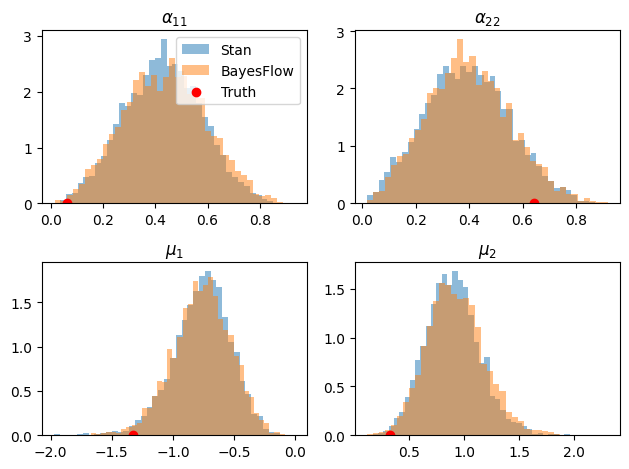

In [154]:
fig, axes = plt.subplots(ncols=2, nrows=2)
axes=axes.flatten()

for i, par in enumerate([r"$\alpha_{11}$", r"$\alpha_{22}$", r"$\mu_1$", r"$\mu_2$"]):
    axes[i].set_title(par)
    axes[i].hist(stan_samples[:,i], density=True, bins=40, alpha = 0.5, label="Stan")
    axes[i].hist(bf_samples[:,i],   density=True, bins=40, alpha = 0.5, label="BayesFlow")
    axes[i].scatter(pars[i], 0, color="red", label="Truth")

axes[0].legend()

fig.tight_layout()